# **Target y Exploraci√≥n de Datos**


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
import warnings
warnings.filterwarnings("ignore")



## **Preprocesamiento de Datos**

En primer lugar, leemos la base de datos desde el csv. Debido al tama√±o del archivo se opt√≥ por acceder por fragmentos al archivo, con el objetivo de optimizar el uso de memoria.

In [3]:

# archivo original
input_file = r"c:\Users\TAWTOCA\Downloads\accepted_2007_to_2018Q4.csv"

# tama√±o de los bloques
chunksize = 200000  

# lista para guardar los fragmentos
df_list = []

for chunk in pd.read_csv(input_file, chunksize=chunksize, low_memory=False):
    df_list.append(chunk)   # guardamos cada bloque

# concatenar todos los fragmentos en un √∫nico DataFrame
df = pd.concat(df_list, ignore_index=True)

print("‚úÖ Dataset cargado con forma:", df.shape)
print("üîç Columnas disponibles:\n", df.columns.tolist())


‚úÖ Dataset cargado con forma: (2260701, 151)
üîç Columnas disponibles:
 ['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annu

### **Creaci√≥n Variable 'Default'**

Se cre√≥ la variable binaria 'default' en base a la variable original 'loan_status'.  Se tiene 'Fully Paid' = 0 y 'Charge Off'/'Default' = 1. Luego se elimina aquellos registros en los que 'default' seria nula.

In [4]:
# Definir categor√≠as
good_status = ["Fully Paid"]
bad_status = ["Charged Off", "Default"]

# Crear nueva variable sin reemplazar la original
df["default"] = df["loan_status"].apply(lambda x: 1 if x in bad_status else (0 if x in good_status else None))

# Filtrar para conservar solo Fully Paid y Charged Off/Default
df = df[df["default"].notnull()].copy()

# Verificar resultados
print(df["loan_status"].value_counts())
print(df["default"].value_counts())

loan_status
Fully Paid     1076751
Charged Off     268559
Default             40
Name: count, dtype: int64
default
0.0    1076751
1.0     268599
Name: count, dtype: int64


In [4]:
print(df.shape)

(1345350, 152)


### **Elecci√≥n de variables**

Para elegir las variables m√°s relevantes para el modelado se utiliz√≥ varias estrategias con el fin de optimizar el proceso. 

1. Eliminar aquellas variables con un porcentaje de valores nulos mayor al 50%. Justificado en el hecho de que no aportar√≠a a los resultados.

In [5]:
null_thresh = 0.5
df = df.loc[:, df.isnull().mean() < null_thresh]
print("‚úÖ Despu√©s de eliminar nulos (>50%):", df.shape)

‚úÖ Despu√©s de eliminar nulos (>50%): (1345350, 94)


2. Eliminar variables con baja variabilidad. Es decir, aquellas donde m√°s del 95% de las filas tiene el mismo valor.

In [5]:
low_variance_cols = [col for col in df.columns 
                     if df[col].nunique(dropna=True) <= 1 or 
                        (df[col].value_counts(normalize=True, dropna=False).iloc[0] > 0.95)]
df.drop(columns=low_variance_cols, inplace=True)
print("‚úÖ Despu√©s de baja varianza:", df.shape)

‚úÖ Despu√©s de baja varianza: (1345350, 100)


3. Eliminar variables de Data Leakage (fuga de informaci√≥n)

In [7]:
leakage_cols = [
    'funded_amnt','funded_amnt_inv','total_pymnt','total_pymnt_inv','total_rec_prncp',
    'total_rec_int','recoveries','collection_recovery_fee','last_pymnt_d',
    'last_pymnt_amnt','last_credit_pull_d','last_fico_range_high','last_fico_range_low'
]
df.drop(columns=[c for c in leakage_cols if c in df.columns], inplace=True, errors="ignore")
print("‚úÖ Despu√©s de quitar leakage:", df.shape)

‚úÖ Despu√©s de quitar leakage: (1345350, 67)


4. Se eliminan las variables que contienen metadatos/identificadores que no aportan al analisis. 

In [8]:

id_cols = ["id", "zip_code", "url"]
df.drop(columns=[c for c in id_cols if c in df.columns], inplace=True, errors="ignore")
print("‚úÖ Despu√©s de quitar IDs/metadatos:", df.shape)

‚úÖ Despu√©s de quitar IDs/metadatos: (1345350, 64)


5. Se modificaron aquellas variables con colinealidad extrema (pares obvios). Para evitar informaci√≥n redundante,

In [9]:
if 'fico_range_high' in df.columns and 'fico_range_low' in df.columns:
    df['fico_mean'] = (df['fico_range_high'] + df['fico_range_low']) / 2
    df.drop(columns=['fico_range_high','fico_range_low'], inplace=True)

if 'grade' in df.columns and 'sub_grade' in df.columns:
    df.drop(columns=['grade'], inplace=True)

if 'funded_amnt' in df.columns and 'loan_amnt' in df.columns:
    df.drop(columns=['funded_amnt'], inplace=True)

print("‚úÖ Despu√©s de manejar colinealidad:", df.shape)

‚úÖ Despu√©s de manejar colinealidad: (1345350, 62)


In [10]:
if 'loan_status' in df.columns:
    df.drop(columns=['loan_status'], inplace=True)

6. Eliminar texto libre dif√≠cil de procesar

In [11]:

text_cols = [ "emp_title", "title"]
df.drop(columns=[c for c in text_cols if c in df.columns], inplace=True, errors="ignore")
print("‚úÖ Despu√©s de quitar texto libre:", df.shape)

‚úÖ Despu√©s de quitar texto libre: (1345350, 59)


In [12]:
# Convertir earliest_cr_line al formato datetime correcto
df["earliest_cr_line"] = pd.to_datetime(df["earliest_cr_line"], format="%b-%Y", errors="coerce")

# Crear columnas de a√±o y mes
df["earliest_cr_line_year"] = df["earliest_cr_line"].dt.year
df["earliest_cr_line_month"] = df["earliest_cr_line"].dt.month

# Eliminar la original
df.drop(columns=["earliest_cr_line"], inplace=True)


In [13]:
print("‚úÖ Dataset final shape:", df.shape)
print("üìå Columnas finales:\n", df.columns.tolist())

‚úÖ Dataset final shape: (1345350, 60)
üìå Columnas finales:
 ['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'to

Como se busca predecir si un pr√©stamo emitido resultar√° en default (1) o ser√° pagado completamente (0), se necesita la informaci√≥n relevante con el prestatario, por lo que aquello que no aporta tambien sera eliminado. Asi como columnas redundantess y tecnicas irrelavantes.

In [14]:
irrelevant_cols = [
    "issue_d",            # fecha de emisi√≥n (introduce sesgo temporal)
    "initial_list_status" # estado inicial de la publicaci√≥n (plataforma, no prestatario)
]
df.drop(columns=[c for c in irrelevant_cols if c in df.columns], inplace=True)


In [15]:
# === 3. Eliminar num√©ricas redundantes ===
redundant_cols = [
    "installment",        # muy correlacionada con loan_amnt e int_rate
    "avg_cur_bal",        # duplicada con tot_cur_bal
    "total_bal_ex_mort",  # redundante con tot_cur_bal
    "total_bc_limit",     # redundante con total_rev_hi_lim
    "total_il_high_credit_limit", # redundante con tot_hi_cred_lim
    "bc_open_to_buy"      # redundante con bc_util
]
df.drop(columns=[c for c in redundant_cols if c in df.columns], inplace=True)

In [16]:
# lista de columnas t√©cnicas a eliminar
cols_drop = [
    "tot_coll_amt", "tot_cur_bal", "total_rev_hi_lim", "tot_hi_cred_lim",
    "total_bal_ex_mort", "total_bc_limit", "total_il_high_credit_limit",
    "bc_open_to_buy", "bc_util", "percent_bc_gt_75", "pct_tl_nvr_dlq",
    "mo_sin_old_il_acct", "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op",
    "mo_sin_rcnt_tl", "mths_since_recent_bc", "mths_since_recent_inq",
    "acc_open_past_24mths", "avg_cur_bal", "num_accts_ever_120_pd",
    "num_actv_bc_tl", "num_actv_rev_tl", "num_bc_sats", "num_bc_tl",
    "num_il_tl", "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", 'clean_emp_length', 'emp_length'
]

# eliminar columnas
df = df.drop(columns=cols_drop, errors="ignore")

print("‚úÖ Dataset reducido:", df.shape)
print("üìå Columnas finales:", df.columns.tolist())


‚úÖ Dataset reducido: (1345350, 23)
üìå Columnas finales: ['loan_amnt', 'term', 'int_rate', 'sub_grade', 'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'default', 'fico_mean', 'earliest_cr_line_year', 'earliest_cr_line_month']


Al final, terminamos con un total de 24 variables y 1345350 registros. Por lo que se procede a realizar el an√°lisis exploratorio de datos.

In [17]:
# === 4. Porcentaje de nulos en las columnas restantes ===
null_percent = df.isnull().mean().sort_values(ascending=False) * 100

print("‚úÖ Shape final:", df.shape)
print("üìå Columnas finales:\n", df.columns.tolist())

print("\nüìä Porcentaje de nulos por variable:")
print(null_percent)

‚úÖ Shape final: (1345350, 23)
üìå Columnas finales:
 ['loan_amnt', 'term', 'int_rate', 'sub_grade', 'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'default', 'fico_mean', 'earliest_cr_line_year', 'earliest_cr_line_month']

üìä Porcentaje de nulos por variable:
mort_acc                  3.514401
revol_util                0.063701
pub_rec_bankruptcies      0.051808
dti                       0.027799
inq_last_6mths            0.000074
term                      0.000000
loan_amnt                 0.000000
verification_status       0.000000
annual_inc                0.000000
home_ownership            0.000000
sub_grade                 0.000000
int_rate                  0.000000
delinq_2yrs               0.000000
addr_state                0.000000
purpose                   0.000000
revol_bal                 0.000000
pub_

In [18]:
df.to_pickle(r"c:\Users\TAWTOCA\Downloads\df.pkl")
df.to_csv(r"c:\Users\TAWTOCA\Downloads\df.csv", index=False)


## **Analisis Exploratorio de Datos**

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo general
sns.set_palette("Blues")

# ----------------------------
# 1. Distribuci√≥n de la variable objetivo (default)
# ----------------------------
def plot_default_distribution(df):
    plt.figure(figsize=(5,5))
    df["default"].value_counts().plot(
        kind="pie", 
        autopct="%1.1f%%", 
        startangle=90, 
        colors=sns.color_palette("Blues", 2),
        wedgeprops={"edgecolor":"white"}
    )
    plt.title("Distribuci√≥n de la variable objetivo (default)")
    plt.ylabel("")
    plt.show()

# ----------------------------
# 2. Variables num√©ricas
# ----------------------------
def plot_numeric(df, col):
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    
    # Histograma
    sns.histplot(df[col], bins=30, kde=True, ax=axes[0], color="steelblue")
    axes[0].set_title(f"Histograma de {col}")
    axes[0].set_xlabel(col)
    axes[0].set_ylabel("Frecuencia")

    # Boxplot por clase default
    sns.boxplot(x="default", y=col, data=df, ax=axes[1], palette="Blues")
    axes[1].set_title(f"{col} vs Default")
    axes[1].set_xlabel("Default")
    axes[1].set_ylabel(col)

    plt.tight_layout()
    plt.show()

# ----------------------------
# 3. Variables categ√≥ricas


def plot_categorical(df, var, target="default"):
    plt.figure(figsize=(8,6))
    counts = df[var].value_counts().sort_values(ascending=False)
    n_cats = len(counts)

    # Caso 1: 2 categor√≠as ‚Üí gr√°fico de anillo
    if n_cats == 2:
        counts.plot.pie(
            autopct="%1.1f%%",
            startangle=90,
            colors=sns.color_palette("Blues", n_colors=n_cats),
            wedgeprops=dict(width=0.4)
        )
        plt.ylabel("")
        plt.title(f"Distribuci√≥n de {var}")

    # Caso 2: hasta 6 categor√≠as ‚Üí circular normal
    elif n_cats <= 6:
        counts.plot.pie(
            autopct="%1.1f%%",
            startangle=90,
            colors=sns.color_palette("Blues", n_colors=n_cats)
        )
        plt.ylabel("")
        plt.title(f"Distribuci√≥n de {var}")

    # Caso 3: m√°s de 6 y hasta 10 ‚Üí barras verticales
    elif n_cats <= 10:
        sns.barplot(x=counts.index, y=counts.values, palette="Blues_r")
        plt.title(f"Distribuci√≥n de {var}")
        plt.ylabel("Frecuencia")
        plt.xticks(rotation=45, ha="right")

    # Caso 4: m√°s de 10 ‚Üí Solo Top 10 por clase default
    else:
        for cls in df[target].unique():
            subset = df[df[target] == cls][var].value_counts().head(10)
            plt.figure(figsize=(8,6))
            sns.barplot(y=subset.index, x=subset.values, palette="Blues_r")
            plt.title(f"Top 10 categor√≠as de {var} | {target}={cls}")
            plt.xlabel("Frecuencia")
            plt.tight_layout()
            plt.show()
        return

    plt.tight_layout()
    plt.show()


### **Distribuci√≥n de la Variable Default**

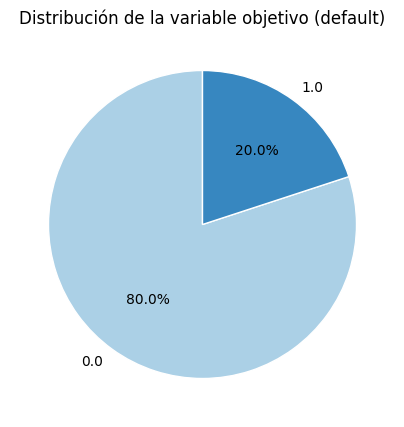

In [20]:
# Target
plot_default_distribution(df)

Este gr√°fico revela un desbalance de clases, ya que la mayor√≠a de los casos corresponde a clientes que no cayeron en default. Este desbalance puede afectar el desempe√±o de modelos de clasificaci√≥n, ya que podr√≠an inclinarse a predecir mayormente la clase mayoritaria.

### **Valores Faltantes y Tipos de Datos**


Valores faltantes por columna:


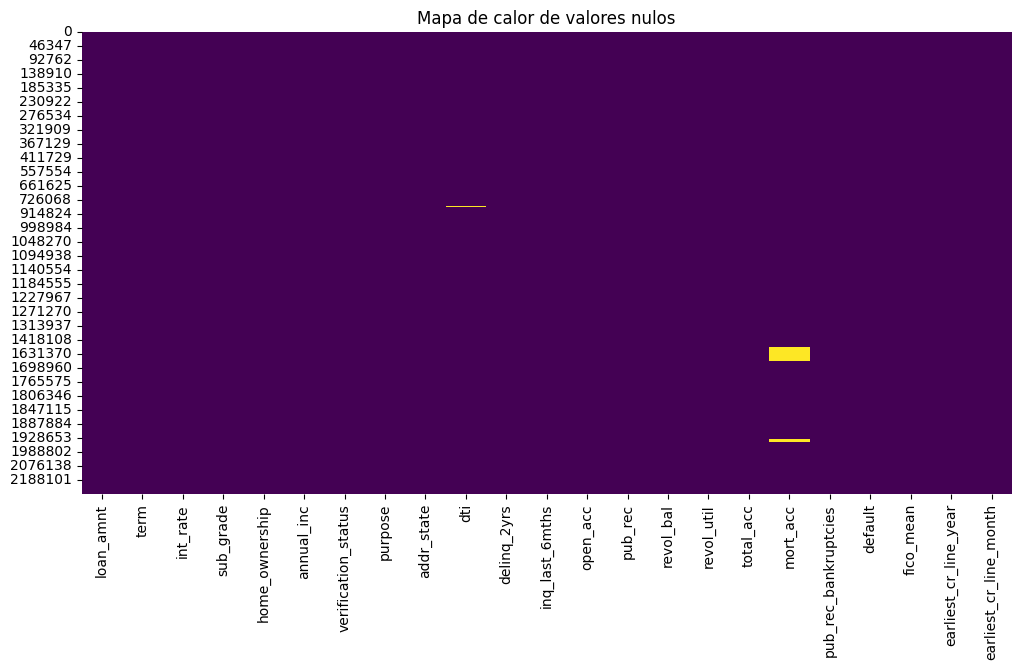


Tipos de datos:


loan_amnt                 float64
term                       object
int_rate                  float64
sub_grade                  object
home_ownership             object
annual_inc                float64
verification_status        object
purpose                    object
addr_state                 object
dti                       float64
delinq_2yrs               float64
inq_last_6mths            float64
open_acc                  float64
pub_rec                   float64
revol_bal                 float64
revol_util                float64
total_acc                 float64
mort_acc                  float64
pub_rec_bankruptcies      float64
default                   float64
fico_mean                 float64
earliest_cr_line_year       int32
earliest_cr_line_month      int32
dtype: object

In [21]:

print("\nValores faltantes por columna:")
df.isnull().sum()


plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Mapa de calor de valores nulos")
plt.show()

print("\nTipos de datos:")
df.dtypes

En general, el conjunto de datos est√° bien completo, ya que la mayor√≠a de las variables no presentan valores nulos. Sin embargo, se observan algunos valores faltantes concentrados en tres columnas: mort_acc, pub_rec_bankruptcies y revol_util. Estas columnas tienen pocos casos nulos en comparaci√≥n con el tama√±o total del dataset, lo que sugiere que podr√≠an ser imputados f√°cilmente (por ejemplo, con la media, mediana o un modelo de predicci√≥n), o eliminados sin afectar significativamente el an√°lisis.

### **Histogramas Variables N√∫mericas**

Para el analisis de las variables numericas se muestran un histograma para visualizar su distribuci√≥n y 

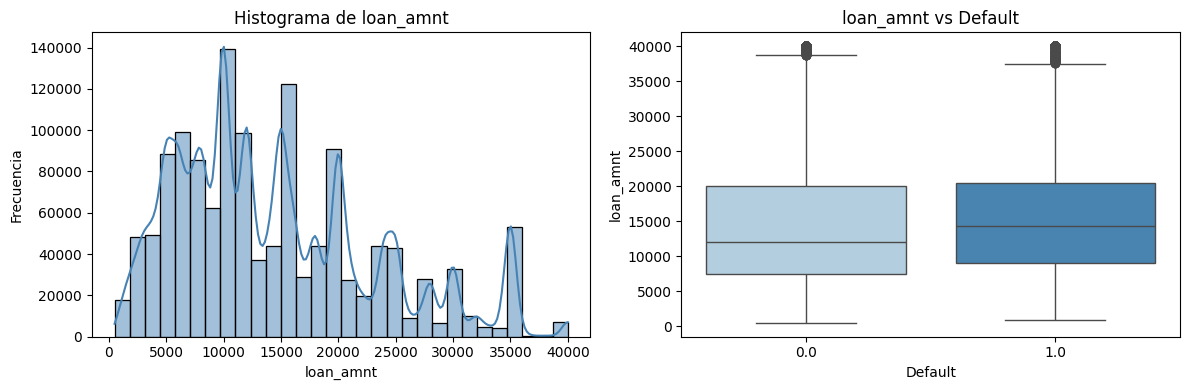

In [22]:
# loan_amnt
plot_numeric(df, "loan_amnt")


El an√°lisis muestra que la mayor√≠a de los pr√©stamos otorgados se concentran entre los 5,000 y 20,000 d√≥lares, con picos espec√≠ficos que sugieren montos estandarizados por la entidad financiera. Al comparar con la variable Default, se observa que los clientes que incumplen tienden a tener montos de pr√©stamo ligeramente m√°s altos que los que no incumplen, aunque la diferencia no es muy marcada. Esto indica que el monto del pr√©stamo podr√≠a influir en el riesgo de incumplimiento, pero no parece ser un factor determinante por s√≠ solo.

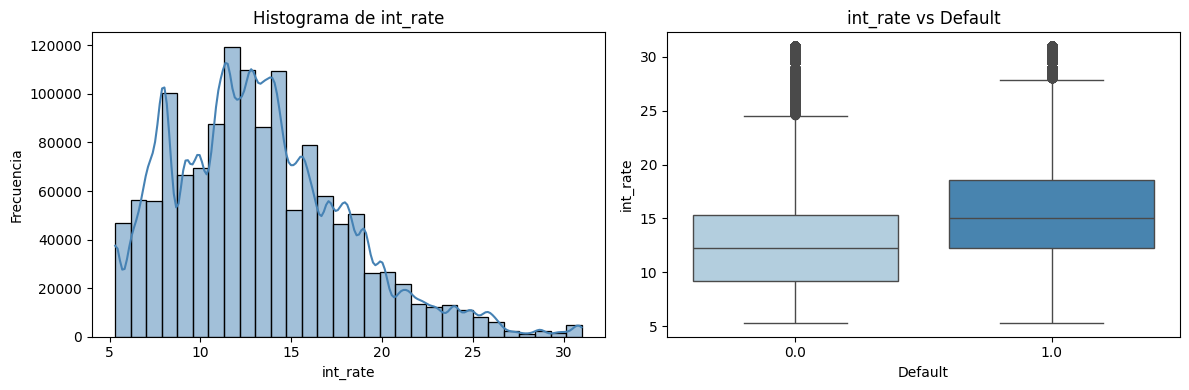

In [23]:
# int_rate
plot_numeric(df, "int_rate")


La distribuci√≥n de las tasas de inter√©s est√° concentrada entre el 8% y el 16%, disminuyendo progresivamente en valores m√°s altos. El boxplot revela que los pr√©stamos en Default suelen tener tasas de inter√©s m√°s elevadas en comparaci√≥n con los que no incumplen, lo que respalda la relaci√≥n entre riesgo percibido y costo del cr√©dito: a mayor tasa, mayor probabilidad de incumplimiento. En este caso, la tasa de inter√©s se presenta como un indicador clave para predecir el default.

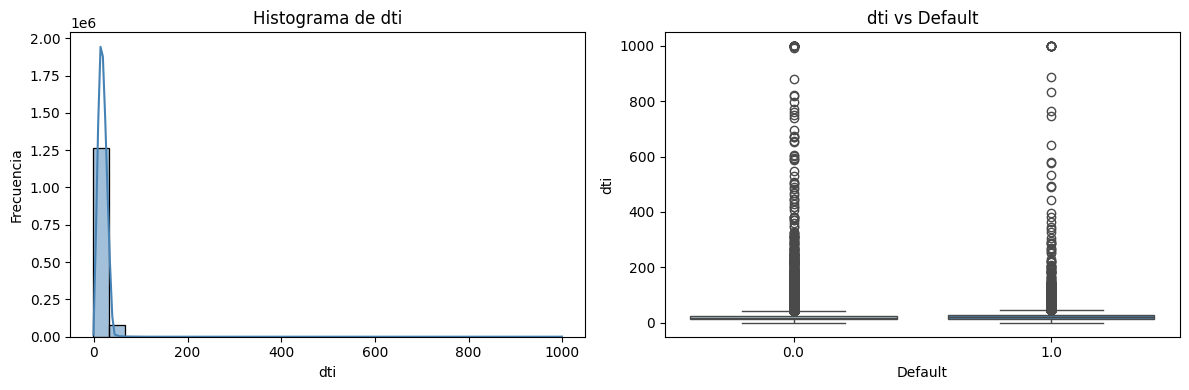

In [24]:
# dti
plot_numeric(df, "dti")


El histograma de la variable dti (debt-to-income ratio) muestra que la gran mayor√≠a de los clientes tienen un valor relativamente bajo, concentrado entre 0 y 40, aunque existen valores extremos que llegan a superar los 1000, lo cual resulta poco com√∫n y probablemente corresponda a outliers o datos at√≠picos. El boxplot refleja esta misma situaci√≥n: la distribuci√≥n central es bastante compacta, pero hay una gran cantidad de valores at√≠picos en ambos grupos de Default.

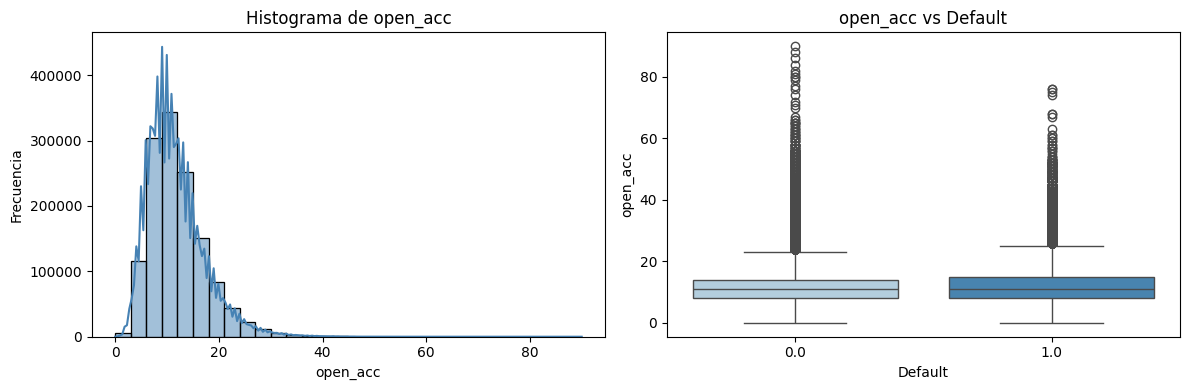

In [25]:
# open_acc
plot_numeric(df, "open_acc")


El histograma de open_acc muestra que la mayor√≠a de los clientes tienen entre 5 y 20 cuentas abiertas, con un claro sesgo a la derecha y algunos casos extremos que superan incluso las 60 cuentas. Esto indica que aunque la mayor parte de las personas mantiene un n√∫mero moderado de cuentas de cr√©dito abiertas, existe una minor√≠a con una cantidad inusualmente alta. En el boxplot, se aprecia que tanto los clientes que incumplen (Default = 1) como los que no incumplen (Default = 0) tienen distribuciones bastante parecidas, con medianas cercanas y un rango intercuart√≠lico similar.

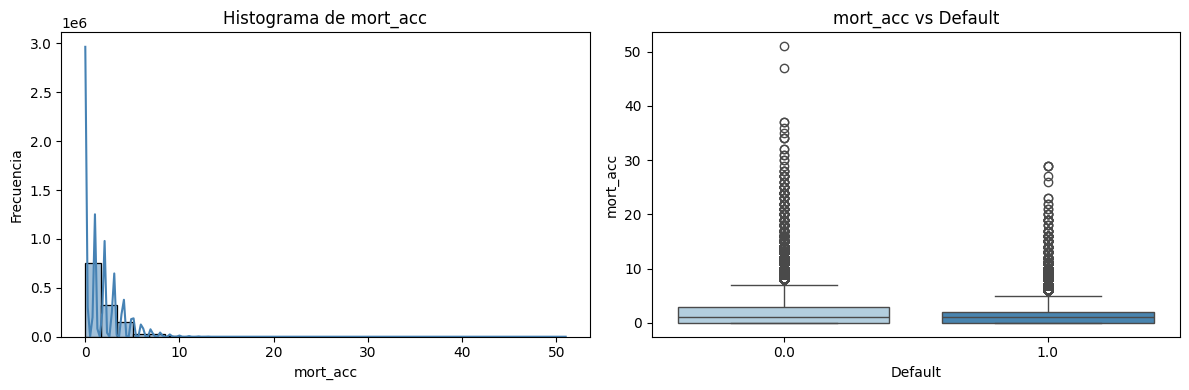

In [26]:
# mort_acc
plot_numeric(df, "mort_acc")


En la variable mort_acc, el histograma evidencia que la mayor√≠a de los clientes tienen entre 0 y 2 cuentas hipotecarias, y que muy pocos superan este rango, mostrando tambi√©n un sesgo hacia la derecha con valores at√≠picos que llegan hasta m√°s de 40. El boxplot refleja que los clientes en Default suelen tener una mediana m√°s baja de cuentas hipotecarias en comparaci√≥n con los que no incumplen, lo que puede indicar que los clientes con m√°s cuentas hipotecarias suelen ser m√°s solventes o tienen m√°s respaldo financiero.

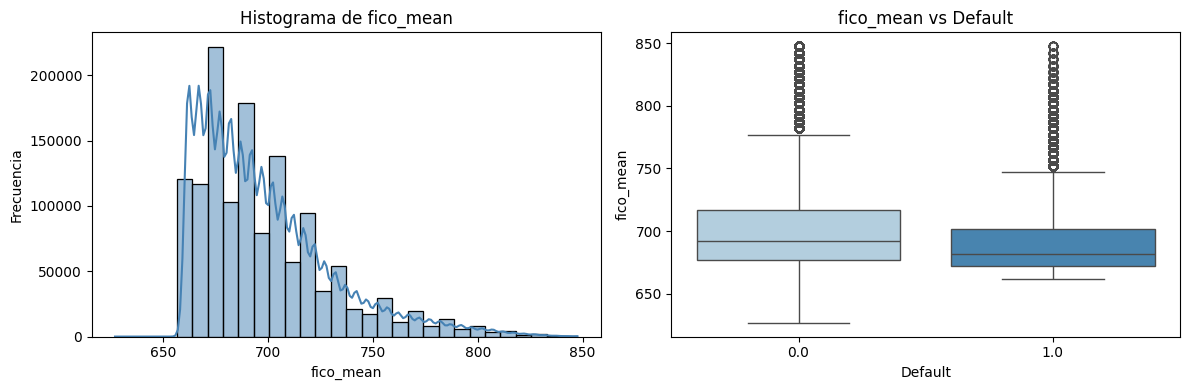

In [27]:
# fico_mean
plot_numeric(df, "fico_mean")


En el caso de fico_mean, el histograma muestra una distribuci√≥n m√°s sim√©trica, concentrada entre 660 y 720 puntos, aunque con valores que llegan hasta los 850. Esto refleja que la mayor√≠a de los clientes tienen un puntaje crediticio dentro del rango considerado aceptable a bueno. El boxplot revela una diferencia m√°s marcada entre los dos grupos: los clientes que incumplen presentan una mediana m√°s baja en comparaci√≥n con los que no incumplen. Adem√°s, aunque ambos grupos tienen outliers con puntajes altos, la tendencia general indica que un menor fico_mean est√° asociado con mayor probabilidad de caer en Default.

### **Variables Categoricas** 

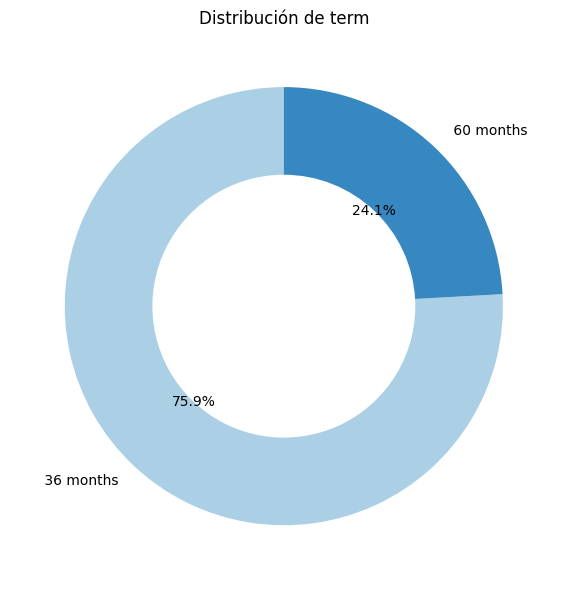

In [28]:
# term
plot_categorical(df, "term")


La distribuci√≥n de la variable term muestra que la mayor√≠a de los pr√©stamos tienen un plazo de 36 meses (75.9%), mientras que solo una cuarta parte corresponde a 60 meses (24.1%). Esto refleja una preferencia clara por pr√©stamos de corto plazo, lo cual es consistente con un menor riesgo de incumplimiento, ya que los plazos m√°s cortos suelen implicar un menor nivel de exposici√≥n y, en general, menor probabilidad de Default. Sin embargo, la existencia de un porcentaje significativo de pr√©stamos a 60 meses indica que una parte importante de los clientes est√° dispuesta a asumir un compromiso financiero m√°s prolongado.

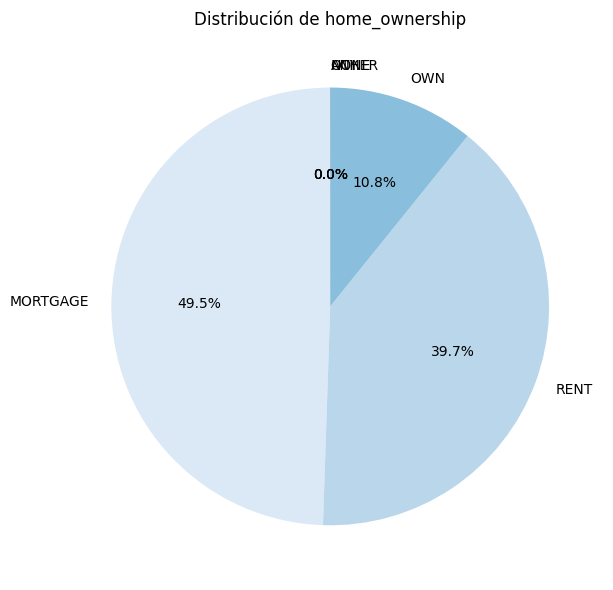

In [29]:
plot_categorical(df, "home_ownership")


En la variable home_ownership, se observa que la mayor√≠a de los clientes se concentran en tres categor√≠as principales: MORTGAGE (hipoteca), RENT (arriendo) y OWN (propiedad), siendo las dos primeras las m√°s frecuentes. Esto sugiere que la base de clientes incluye tanto personas con vivienda propia hipotecada como arrendatarios en proporciones muy similares. Los casos de ANY, OTHER y NONE son minoritarios, lo que indica situaciones menos comunes de tenencia de vivienda.

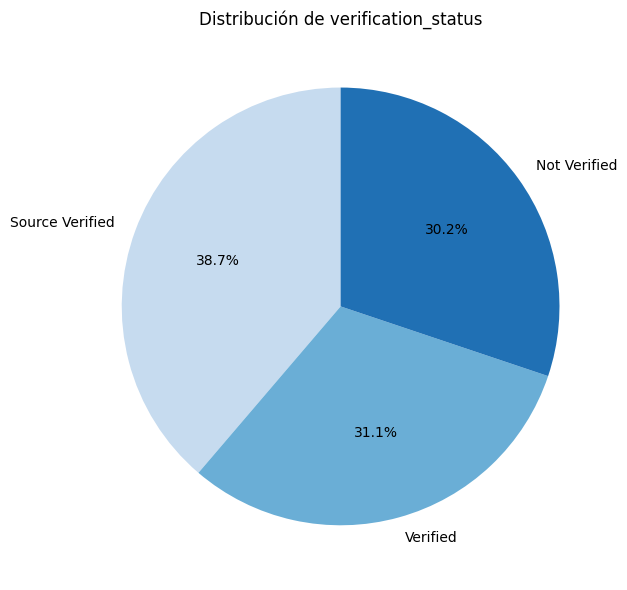

In [30]:
# verification_status
plot_categorical(df, "verification_status")


La variable verification_status muestra que la mayor√≠a de los clientes tienen alg√∫n grado de verificaci√≥n de sus ingresos: Source Verified (38.7%) y Verified (31.1%), mientras que un 30.2% no tiene verificaci√≥n (Not Verified). El hecho de que casi el 70% de los casos cuente con verificaci√≥n sugiere que la entidad crediticia otorga importancia a este proceso para reducir el riesgo de fraude o de informaci√≥n falsa. 

<Figure size 800x600 with 0 Axes>

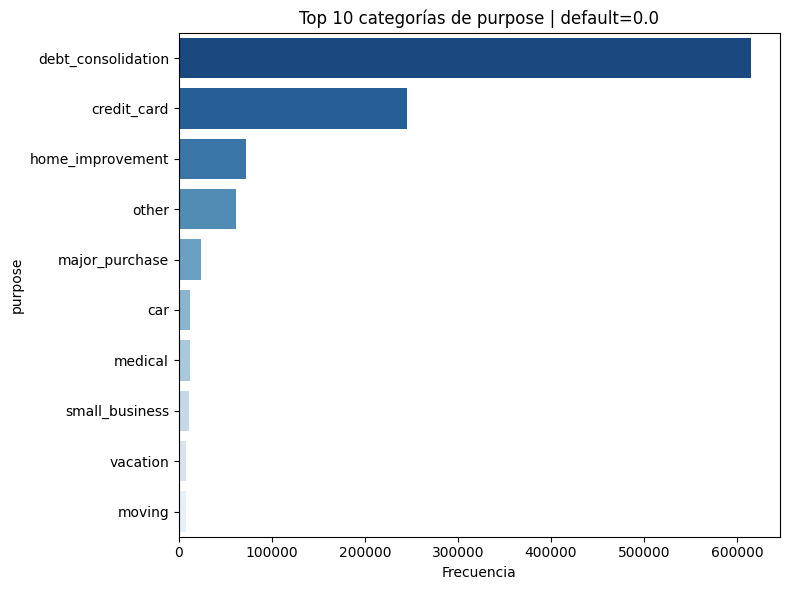

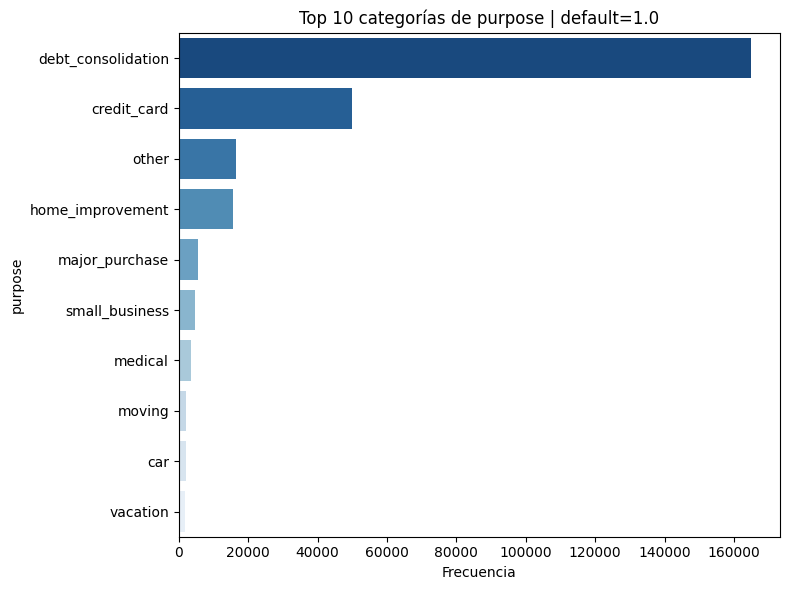

In [31]:
# purpose
plot_categorical(df, "purpose")


En el primer gr√°fico se observa que la mayor√≠a de los pr√©stamos concedidos a clientes que no cayeron en Default se concentran principalmente en la categor√≠a debt_consolidation (consolidaci√≥n de deudas), que supera con creces a todas las dem√°s con m√°s de 600,000 registros. En segundo lugar se encuentra credit_card, que tambi√©n representa un volumen significativo de clientes con cerca de 250,000 casos. Las siguientes categor√≠as como home_improvement, other y major_purchase tienen una participaci√≥n mucho menor en comparaci√≥n, y las categor√≠as car, medical, small_business, vacation y moving son a√∫n menos frecuentes. Esto indica que los pr√©stamos relacionados con el manejo de deudas y tarjetas de cr√©dito son los m√°s comunes entre los clientes cumplidos.

En el segundo gr√°fico, que muestra los clientes que s√≠ cayeron en Default, la distribuci√≥n se mantiene con un patr√≥n muy similar al de los cumplidos: debt_consolidation sigue siendo la categor√≠a dominante, seguida de credit_card. Sin embargo, proporcionalmente, las categor√≠as de other y home_improvement adquieren mayor peso dentro del grupo en incumplimiento, lo que sugiere que estos prop√≥sitos pueden conllevar un mayor riesgo relativo de no pago. Al igual que en los clientes sin Default, las categor√≠as de menor frecuencia siguen siendo vacation, car y moving, lo que indica que no representan un volumen significativo de incumplimientos, aunque podr√≠an ser riesgosas en casos particulares por el tipo de gasto que implican.

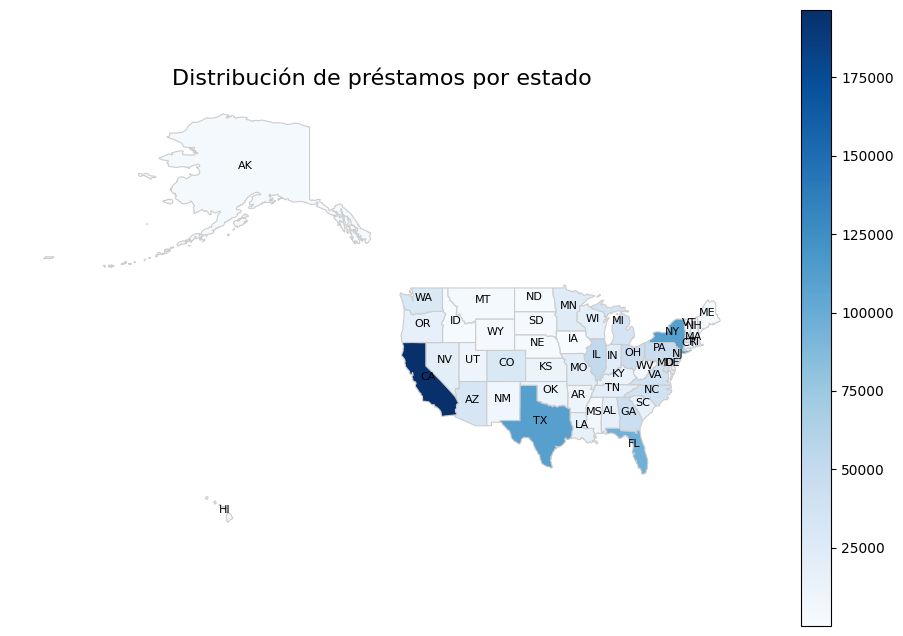

In [54]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

def plot_us_states_matplotlib(df, col="addr_state"):
    # Mapeo de c√≥digos de estados a nombres completos
    state_map = {
        "AL": "Alabama", "AK": "Alaska", "AZ": "Arizona", "AR": "Arkansas",
        "CA": "California", "CO": "Colorado", "CT": "Connecticut", "DE": "Delaware",
        "FL": "Florida", "GA": "Georgia", "HI": "Hawaii", "ID": "Idaho",
        "IL": "Illinois", "IN": "Indiana", "IA": "Iowa", "KS": "Kansas",
        "KY": "Kentucky", "LA": "Louisiana", "ME": "Maine", "MD": "Maryland",
        "MA": "Massachusetts", "MI": "Michigan", "MN": "Minnesota", "MS": "Mississippi",
        "MO": "Missouri", "MT": "Montana", "NE": "Nebraska", "NV": "Nevada",
        "NH": "New Hampshire", "NJ": "New Jersey", "NM": "New Mexico", "NY": "New York",
        "NC": "North Carolina", "ND": "North Dakota", "OH": "Ohio", "OK": "Oklahoma",
        "OR": "Oregon", "PA": "Pennsylvania", "RI": "Rhode Island", "SC": "South Carolina",
        "SD": "South Dakota", "TN": "Tennessee", "TX": "Texas", "UT": "Utah",
        "VT": "Vermont", "VA": "Virginia", "WA": "Washington", "WV": "West Virginia",
        "WI": "Wisconsin", "WY": "Wyoming"
    }

    # Contar pr√©stamos por estado
    df_state_counts = df[col].value_counts().reset_index()
    df_state_counts.columns = ["state_abbr", "count"]
    df_state_counts["state"] = df_state_counts["state_abbr"].map(state_map)

    # Leer shapefile de estados de EE.UU. desde un GeoJSON p√∫blico
    url = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"
    states = gpd.read_file(url)

    # Unir con nuestros datos
    merged = states.merge(df_state_counts, left_on="name", right_on="state", how="left")

    # Graficar
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    merged.plot(column="count", cmap="Blues", linewidth=0.8, ax=ax, edgecolor="0.8", legend=True)
    ax.set_title("Distribuci√≥n de pr√©stamos por estado", fontsize=16)
    ax.axis("off")

    # Agregar etiquetas con siglas
    for idx, row in merged.iterrows():
        if row["state_abbr"] in state_map.keys():  # evitar NaN
            plt.annotate(
                text=row["state_abbr"],
                xy=(row["geometry"].centroid.x, row["geometry"].centroid.y),
                ha="center", fontsize=8, color="black"
            )

    plt.show()


    
# Llamar a la funci√≥n para graficar
plot_us_states_matplotlib(df, col="addr_state")


In [49]:
import plotly.express as px

def plot_us_states_interactive(df, col="addr_state"):
    state_counts = df[col].value_counts().reset_index()
    state_counts.columns = ["state", "count"]

    fig = px.choropleth(
        state_counts,
        locations="state",
        locationmode="USA-states",
        color="count",
        scope="usa",
        color_continuous_scale="Blues",
        title="Distribuci√≥n de pr√©stamos por estado"
    )
    fig.show()
plot_us_states_interactive(df, col="addr_state")

El mapa de calor por estados muestra que la mayor concentraci√≥n de pr√©stamos se da en California, seguido por Texas, Florida y Nueva York. Estos estados destacan no solo por el n√∫mero de pr√©stamos, sino tambi√©n porque representan las zonas con mayor densidad de poblaci√≥n y actividad econ√≥mica en Estados Unidos, lo que explica en gran medida la mayor demanda de cr√©dito. En contraste, estados menos poblados como los del medio oeste y noroeste presentan una frecuencia significativamente menor de pr√©stamos. Esta distribuci√≥n geogr√°fica permite identificar √°reas clave para el mercado crediticio, a la vez que sugiere que el riesgo de incumplimiento podr√≠a variar seg√∫n las condiciones econ√≥micas y demogr√°ficas locales.

### **Matriz de Correlaci√≥n**

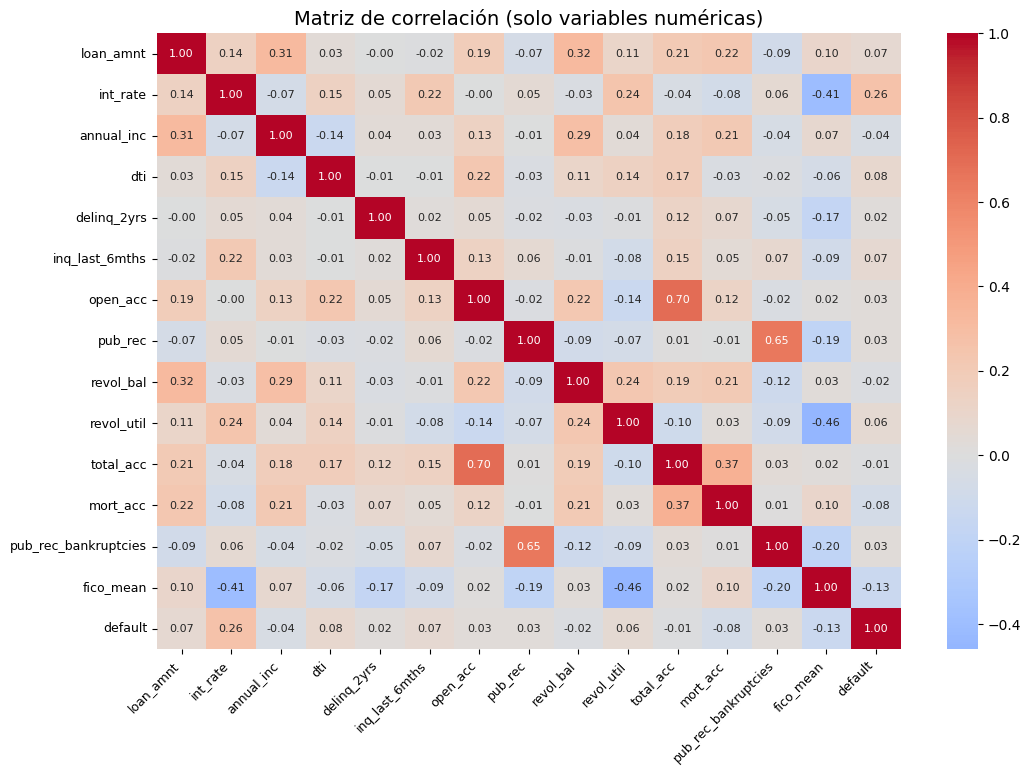

In [34]:
# ----------------------------
# 1. Variables num√©ricas finales
# ----------------------------
num_cols = [
    "loan_amnt", "int_rate", "annual_inc", "dti", "delinq_2yrs", 
    "inq_last_6mths", "open_acc", "pub_rec", "revol_bal", "revol_util", 
    "total_acc", "mort_acc", "pub_rec_bankruptcies", "fico_mean"
]

# ----------------------------
# 2. Subset de dataframe con num√©ricas + default
# ----------------------------
df_corr = df[num_cols + ["default"]]

# ----------------------------
# 3. Matriz de correlaci√≥n con √≠ndices
# ----------------------------
plt.figure(figsize=(12,8))
corr = df_corr.corr()
sns.heatmap(
    corr, 
    cmap="coolwarm", 
    center=0, 
    cbar=True, 
    annot=True,       # valores dentro de cada celda
    fmt=".2f",        # formato num√©rico
    annot_kws={"size":8}  # tama√±o de fuente de los n√∫meros
)
plt.title("Matriz de correlaci√≥n (solo variables num√©ricas)", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.show()




Se observa que la mayor√≠a de las correlaciones con la variable objetivo default (incumplimiento) son bajas, siendo la m√°s destacada la tasa de inter√©s (int_rate) con una correlaci√≥n positiva de 0.26, lo que sugiere que a mayor tasa, mayor probabilidad de incumplimiento. Tambi√©n destaca una correlaci√≥n negativa entre el puntaje FICO (fico_mean) y default (-0.13), indicando que personas con mejor historial crediticio tienden a incumplir menos. Por otro lado, algunas variables est√°n fuertemente correlacionadas entre s√≠, como total_acc con open_acc (0.70), lo que puede se√±alar redundancia en los datos.